In [7]:
import tensorflow as tf
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras import layers, models, Model
import numpy as np
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import fbeta_score
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
input_shape = 300 # Replace None with the fixed sequence

def unet_1d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(inputs)
    conv1 = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(pool1)
    conv2 = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(pool2)
    conv3 = layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(conv3)
    pool3 = layers.MaxPooling1D(pool_size=3)(conv3)
    
    # Bottleneck
    conv4 = layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(pool3)
    conv4 = layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(conv4)
    
    # Decoder
    up5 = layers.UpSampling1D(size=3)(conv4)
    concat5 = layers.Concatenate()([up5, conv3])
    conv5 = layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(concat5)
    conv5 = layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(conv5)
    
    up6 = layers.UpSampling1D(size=2)(conv5)
    concat6 = layers.Concatenate()([up6, conv2])
    conv6 = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(concat6)
    conv6 = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(conv6)
    
    up7 = layers.UpSampling1D(size=2)(conv6)
    concat7 = layers.Concatenate()([up7, conv1])
    conv7 = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(concat7)
    conv7 = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(conv7)
    
    # Output
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation="softmax")(conv7)
    
    model = models.Model(inputs, outputs)
    return model

# Model Parameters
input_shape = (input_shape, 6)  
num_classes = 7
model = unet_1d(input_shape, num_classes)

# Model Summary
model.summary()

2024-12-17 16:11:39.057469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 16:11:39.086347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 16:11:39.086403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 16:11:39.090392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 16:11:39.090493: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 6)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 300, 64)              1216      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 300, 64)              12352     ['conv1d[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 150, 64)              0         ['conv1d_1[0][0]']            
 D)                                                                                           

In [3]:
x_train =np.load('X_train.npy',allow_pickle=True)
y_train =np.load('y_train.npy',allow_pickle=True)

x_val =np.load('X_val.npy',allow_pickle=True)
y_val =np.load('y_val.npy',allow_pickle=True)

In [4]:
def fbeta(y_true, y_pred, beta=1):
    y_pred = K.round(y_pred)  # Round predictions to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    beta_squared = beta ** 2
    fbeta_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return K.mean(fbeta_score)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_fbeta', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_fbeta', patience=200, mode='max')

# Focal loss for multi-class classification
focal_loss = SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0)

model.compile(optimizer='adam',
              loss=focal_loss,  # Replace with focal_loss or your implementation
              metrics=[fbeta])  # Include custom F-beta metric


In [5]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=2000,
                    shuffle=True,
                    callbacks=[checkpoint, early_stopping])

# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

Epoch 1/2000


2024-12-17 16:11:53.777224: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-17 16:11:53.963976: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 16:11:54.453605: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 16:11:56.671291: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f105ce79910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-17 16:11:56.671328: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-12-17 16:11:56.675626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734448316.731649   48199 devic

8/8 [==============================] - ETA: 0s - loss: 7.7626 - fbeta: 0.0666

2024-12-17 16:12:02.964388: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-17 16:12:02.993631: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
/home/user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 14s 759ms/step - loss: 7.7626 - fbeta: 0.0666 - val_loss: 5.9374 - val_fbeta: 0.0842
Epoch 2/2000
8/8 [==============================] - 0s 26ms/step - loss: 2.8906 - fbeta: 0.1172 - val_loss: 2.4767 - val_fbeta: 0.0786
Epoch 3/2000
8/8 [==============================] - 1s 82ms/step - loss: 1.6562 - fbeta: 0.1055 - val_loss: 0.9018 - val_fbeta: 0.0902
Epoch 4/2000
8/8 [==============================] - 0s 24ms/step - loss: 0.6982 - fbeta: 0.0946 - val_loss: 0.5581 - val_fbeta: 0.0475
Epoch 5/2000
8/8 [==============================] - 0s 23ms/step - loss: 0.4169 - fbeta: 0.0723 - val_loss: 0.4476 - val_fbeta: 0.0170
Epoch 6/2000
8/8 [==============================] - 0s 29ms/step - loss: 0.3569 - fbeta: 0.0394 - val_loss: 0.4104 - val_fbeta: 0.0259
Epoch 7/2000
8/8 [==============================] - 0s 23ms/step - loss: 0.3262 - fbeta: 0.0496 - val_loss: 0.3740 - val_fbeta: 0.0184
Epoch 8/2000
8/8 [==============================] - 0s 26ms/step -

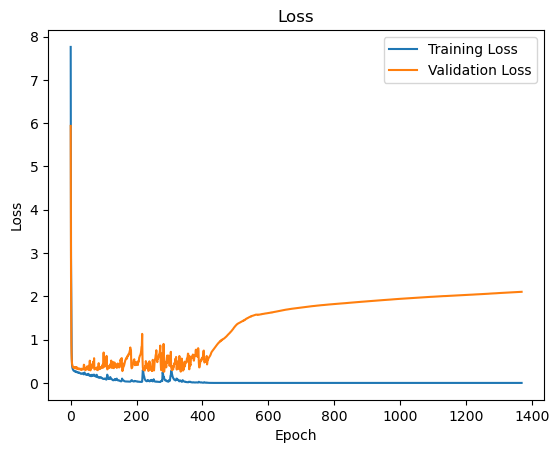

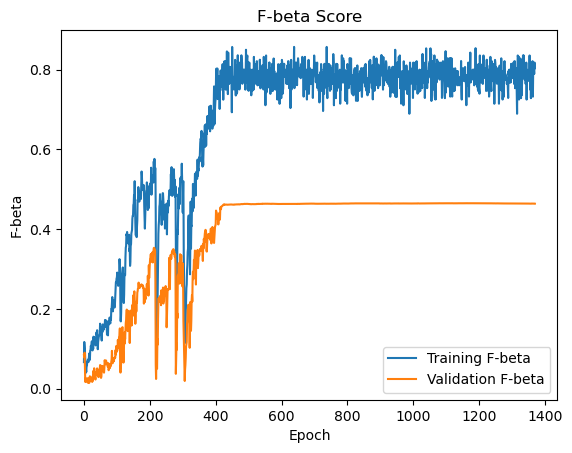

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot F-beta score
plt.plot(history.history['fbeta'], label='Training F-beta')
plt.plot(history.history['val_fbeta'], label='Validation F-beta')
plt.title('F-beta Score')
plt.xlabel('Epoch')
plt.ylabel('F-beta')
plt.legend()
plt.show()


In [15]:
# Convert one-hot encoded labels to class indices
y_true_classes = np.argmax(y_val, axis=-1).flatten()  # True labels
y_pred_classes = np.argmax(model.predict(x_val), axis=-1).flatten()  # Predicted labels

2/2 [==============================] - 0s 30ms/step


In [16]:
y_pred_classes.shape

(12900,)

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 330   32    0    0    0    0    0]
 [ 162 2389    6    2    0    0  323]
 [   0    1  515    0    0    0   25]
 [  46    0    8  546    0    0    0]
 [   0   76    0    0 1285   10  129]
 [ 351  632  182  137   53 1373  573]
 [ 247  846  128  151   36   62 2244]]


In [23]:
activity_mapping = {
    0: 'S',
    1: 'A',
    2: 'P',
    3: 'T',
    4: 'M',
    5: 'kiné',
    6: 'none'
}

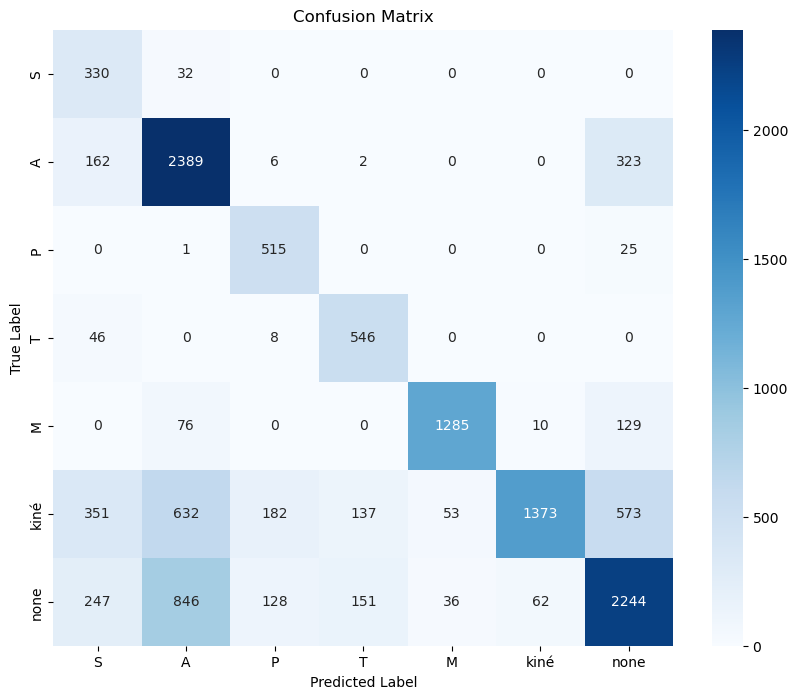

In [24]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(activity_mapping.values()), yticklabels=list(activity_mapping.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()